# TD3 电磁式阻尼器振动控制训练

本notebook用于训练基于GRU网络架构的TD3算法，用于电磁式阻尼器的振动控制，

## 主要特点
- 使用TD3（Twin Delayed Deep Deterministic Policy Gradient）算法
- 可以输入时间序列
- 针对电磁式阻尼器系统的振动控制优化

### 训练参数

In [1]:
# 参数设置
train_model = True

# 环境参数
ENV_PARAMS = {
    'Ts': 0.001,  # 采样时间
    'T': 1.0,    # 仿真时长
    'state0':[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], # 初始状态
    # 观测状态列表
    # 0: 吸振器位移 (x1)
    # 1: 吸振器速度 (v1)
    # 2: 吸振器加速度 (a1)
    # 3: 平台位移 (x2)
    # 4: 平台速度 (v2)
    # 5: 平台加速度 (a2)
    'observation_indices': [0,1,2,3,4,5],  # 观测状态索引
    'x1_limit': 10000,      # x1 位移限制
    'use_dt_noise': False,    # 使用时间步长噪声
    'dt_noise_std': 0.1,       # 时间步长噪声标准差
}

# TD3参数
TD3_PARAMS = {
    'state_dim': len(ENV_PARAMS['observation_indices']),  # 观测维度（平台位移）
    'hidden_dim': 256,          # 隐藏层维度
    'action_bound': 5.0,        # 动作范围
    'actor_lr': 3e-5,           # Actor学习率
    'critic_lr': 3e-4,          # Critic学习率
    'gamma': 0.99,              # 折扣因子
    'tau': 0.002,               # 软更新参数
    'policy_noise': 0.2,        # 策略噪声
    'noise_clip': 0.5,          # 噪声裁剪
    'policy_freq': 2,           # 策略更新频率
    'sigma': 0.02,              # 探索噪声
    'rand_prob': 0,             # 随机动作概率
    'clip_grad': True,         # 是否裁剪梯度
    'seq_len' : 100,             # GRU序列长度
    'pre_seq_len': 8,         # 预测时间步长度
    'gru_layers': 1,              # GRU层数
    'aware_dt': False,           # 是否感知时间步长
    'aware_delay_time': False,   # 是否感知动作延迟时间
    'delay_enabled': True,      # 是否启用动作延迟
    'delay_step': 1,            # 动作延迟步数均值
    'delay_sigma': 0             # 动作延迟步数标准差
}

# 训练参数
TRAIN_PARAMS = {
    'tolerance': 0.0002,          # 容忍度
    'n_episodes': 400,           # 训练轮次
    'capacity': int(1e5),       # 经验回放池容量
    'min_buffer_size': int(5e3),# 最小缓冲区大小
    'print_interval': 5,        # 打印间隔
    'save_interval': 5,         # 保存间隔
    'batch_size': 128,         # 批次大小
    }

### 仿真环境搭建

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import logging
from datetime import datetime
import os

# 导入自定义模块
from TD3 import Gru_TD3Agent
from nn import Gru_ReplayBuffer
from env import ElectromagneticDamperEnv
from train import train_td3
from af import Datasets, STATES_NAME, plot_compare_no_control

# 设置中文字体和GPU
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 检查GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # 设置随机种子
# np.random.seed(42)
# torch.manual_seed(42)
print(f"使用设备: {device}")

使用设备: cuda


In [3]:
# 日志文件
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
# 创建保存模型的基础目录
base_dir = ".\\savedata"
os.makedirs(base_dir, exist_ok=True)

# 确认项目文件夹
project_name = input("请输入加载/创建项目的名称 (父目录: .\\savedata) ").strip()
project_path = os.path.join(base_dir, project_name)

# 检查项目文件夹是否存在
is_new_project = not os.path.exists(project_path)
os.makedirs(project_path, exist_ok=True)

# 创建检查点保存目录
save_checkpoint_path = os.path.join(project_path, "checkpoints")
os.makedirs(save_checkpoint_path, exist_ok=True)

# 创建绘图保存目录
save_plot_path = os.path.join(project_path, "plots")
os.makedirs(save_plot_path, exist_ok=True)

# 创建日志文件
if not is_new_project:
    assign_log = input("是否指定日志文件？(路径/n) ").strip().lower()
    if assign_log == 'n' or assign_log == '':
        file_path = os.path.join(project_path, f'training_log_{current_time}.log')
    else:
        file_path = assign_log
        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))
else:
    file_path = os.path.join(project_path, f'training_log_{current_time}.log')

logging.basicConfig(filename=file_path,  # 如果指定日志文件，则使用指定路径，否则不写入文件
                level=logging.INFO,          # 设置日志级别
                format='%(asctime)s - %(levelname)s - %(message)s')  # 设置日志格式
logging.info("## 当前时间: %s", datetime.now())
logging.info("项目保存目录: %s", project_path)
logging.info("日志文件: %s", file_path)
logging.info("训练模式: %s", train_model)
logging.info("模型保存目录: %s", save_checkpoint_path)
logging.info("绘图保存目录: %s", save_plot_path)
logging.info("使用设备: %s", device)
logging.info("环境参数: %s", ENV_PARAMS)
logging.info("算法参数: %s", TD3_PARAMS)
logging.info("训练参数: %s", TRAIN_PARAMS)
print(f"日志文件: {file_path}")

日志文件: .\savedata\10_9上午GRU固定延迟训练（-1时间步）测试架构修正2加权得分法，修改了评估网络的架构\training_log_20251009_112835.log


In [4]:
# 系统参数
m = 1.0    # 电磁吸振器质量
M = 15  # 待减振对象质量
k_m = 30_000  # 电磁吸振器刚度
k_M = 300_000  # 平台刚度
k_f = 500  # 电—力常数 N/A
k_E = 0.0  # 作动器反电动势系数
L = 0.0045  # 线圈的电感
R_m = 5.0  # 线圈的电阻
c_m = 1.0  # 电磁吸振器阻尼
c_M = 5.0  # 平台阻尼

# 状态空间矩阵（来自MATLAB文件）
A = np.array([
    [0.0,    1.0,       0.0,         0.0],
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [0.0,    0.0,       0.0,         1.0],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

B = np.array([[0.0], [k_f/m], [0.0], [-k_f/M]])

C = np.array([
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

D = np.array([[+k_f/m], [-k_f/M]])

E = np.array([
    [0.0, 0.0, 0.0, c_M/M],
    [0.0, 0.0, 0.0, k_M/M]
]).T

F = np.array([[0.0], [0.0], [0.0], [1/M]]) # 直接扰动力的输入矩阵

logging.info("系统参数: m=%.2f, M=%.2f, k_m=%.2f, k_M=%.2f, k_f=%.2f, k_E=%.2f, L=%.4f, R_m=%.2f, c_m=%.2f, c_M=%.2f", 
             m, M, k_m, k_M, k_f, k_E, L, R_m, c_m, c_M)

In [5]:
# 定义扰动函数和奖励函数
import inspect

from fx import zero, sin_wave
z_func = zero
# z_func = sin_wave(amplitude=0.005, frequency=30, phase=0)
from fx import tolerance_if_rf
r_func = tolerance_if_rf(tolerance=TRAIN_PARAMS['tolerance'])
f_func = sin_wave(amplitude=300, frequency=40, phase=0)

if train_model: logging.info("正弦扰动函数已定义: %s", inspect.getsource(z_func))
if train_model: logging.info("奖励函数已定义: %s", inspect.getsource(r_func))
if train_model: logging.info("外部扰动函数已定义: %s", inspect.getsource(f_func))

In [6]:
# 初始化环境
env = ElectromagneticDamperEnv(
    A=A, B=B, C=C, D=D, E=E,F=F,
    Ts=ENV_PARAMS['Ts'],  # 采样时间
    T=ENV_PARAMS['T'],    # 仿真时长
    z_func=z_func,
    r_func=r_func,
    f_func=f_func,
    state0=np.array(ENV_PARAMS['state0']),  # 初始状态
    obs_indices=ENV_PARAMS['observation_indices'],  # 观测状态索引
    x1_limit=ENV_PARAMS['x1_limit'],  # x1 位移限制
    use_dt_noise=ENV_PARAMS['use_dt_noise'], # 是否使用时间步长噪声
    dt_noise_std=ENV_PARAMS['dt_noise_std'], # 时间步长噪声标准差
)

logging.info("环境初始化完成，观测维度: %s", [STATES_NAME[idx] for idx in ENV_PARAMS['observation_indices']])
print(f"环境初始化完成，观测维度: {[STATES_NAME[idx] for idx in ENV_PARAMS['observation_indices']]}")

环境初始化完成，观测维度: ['吸振器位移 (x1)', '吸振器速度 (v1)', '吸振器加速度 (a1)', '平台位移 (x2)', '平台速度 (v2)', '平台加速度 (a2)']


仿真进度: 100%|██████████| 1000/1000 [00:00<00:00, 9198.90it/s]


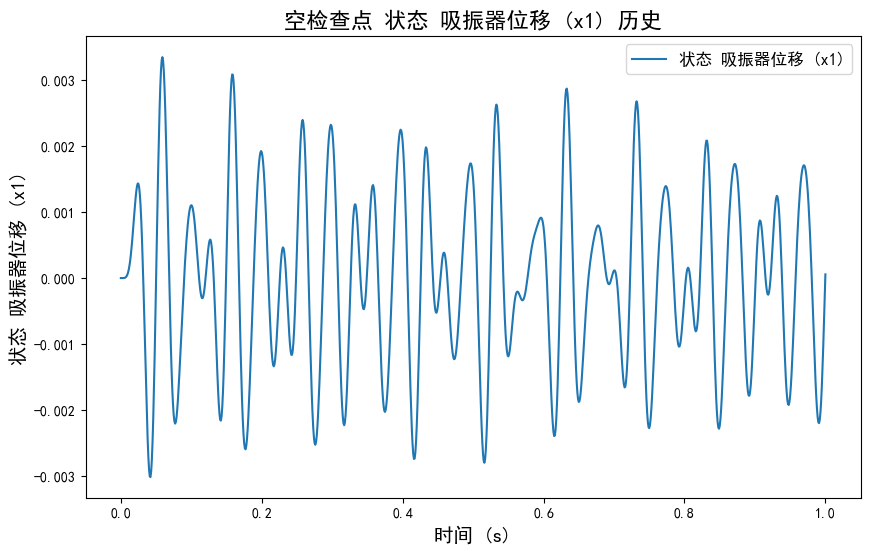

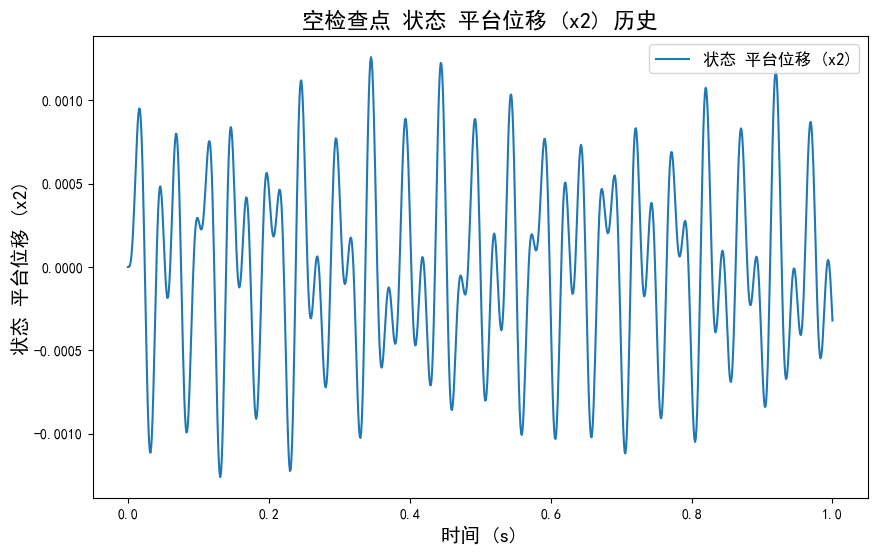

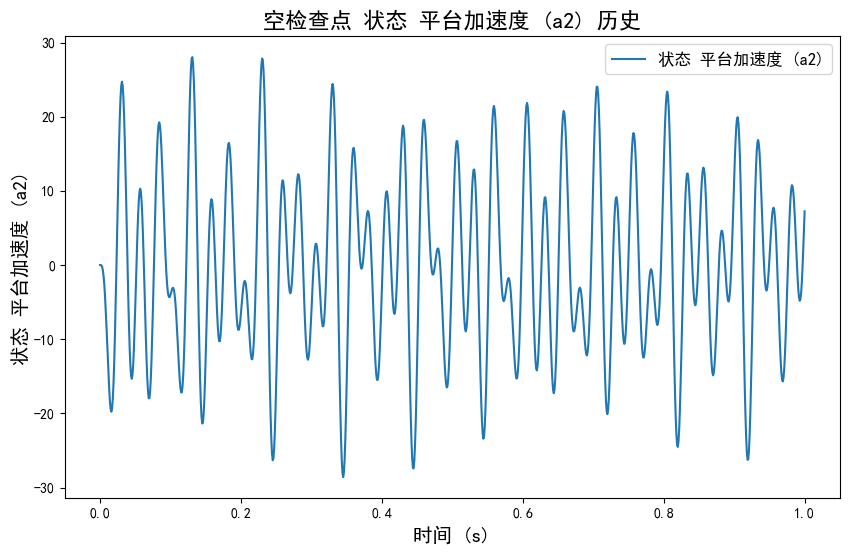

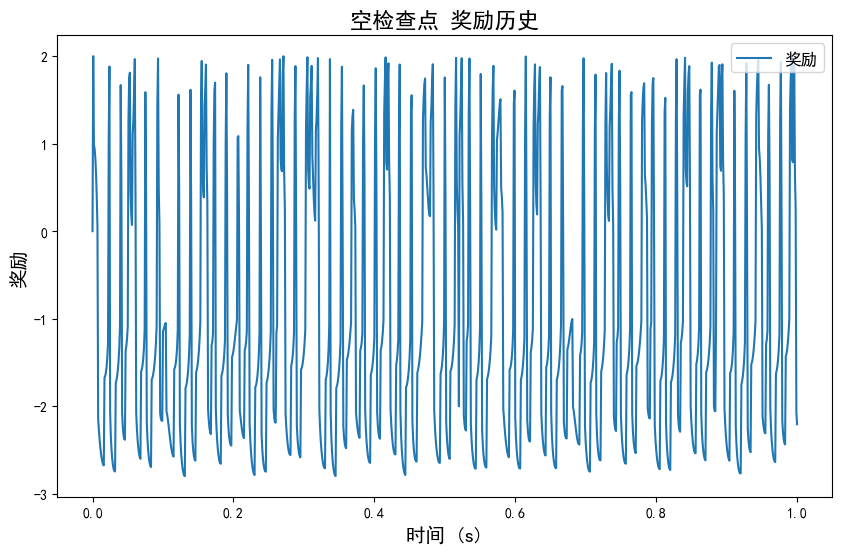

In [7]:
# 环境测试
test_datasets = env.run_simulation()
test_datasets.plot_episode_history(plot_state=[0, 3, 5], plot_reward=True, save_path=save_plot_path, show=True)

In [8]:
# 初始化GRU-TD3代理
agent = Gru_TD3Agent(
    state_dim = len(ENV_PARAMS['observation_indices']) + int(TD3_PARAMS['aware_dt']) + int(TD3_PARAMS['aware_delay_time']), # 观测维度 + 是否感知时间步长 + 是否感知动作延迟时间
    action_dim=1,
    hidden_dim=TD3_PARAMS['hidden_dim'],
    action_bound=TD3_PARAMS['action_bound'],
    actor_lr=TD3_PARAMS['actor_lr'],
    critic_lr=TD3_PARAMS['critic_lr'],
    gamma=TD3_PARAMS['gamma'],
    tau=TD3_PARAMS['tau'],
    policy_noise=TD3_PARAMS['policy_noise'],
    noise_clip=TD3_PARAMS['noise_clip'],
    policy_freq=TD3_PARAMS['policy_freq'],
    sigma=TD3_PARAMS['sigma'],
    clip_grad=TD3_PARAMS['clip_grad'],
    seq_len=TD3_PARAMS['seq_len'],  # GRU序列长度
    pre_seq_len=TD3_PARAMS['pre_seq_len'],  # 预测时间步长度
    gru_layers=TD3_PARAMS['gru_layers'],  # GRU层数
    aware_dt=TD3_PARAMS['aware_dt'],  # 是否感知时间步长
    aware_delay_time=TD3_PARAMS['aware_delay_time'],  # 是否感知动作延迟时间
    delay_enabled=TD3_PARAMS['delay_enabled'],  # 是否启用动作延迟
    delay_step=TD3_PARAMS['delay_step'],  # 动作延迟步数均值
    delay_sigma=TD3_PARAMS['delay_sigma'] # 动作延迟步数标准差
)
logging.info("TD3代理初始化完成")
print("TD3代理初始化完成")

# 写入网络架构到日志
logging.info(f"Actor网络架构:{agent.actor}")
logging.info(f"Critic网络架构:{agent.critic1}")

# 初始化经验回放池
replay_buffer = Gru_ReplayBuffer(
    capacity=TRAIN_PARAMS['capacity'],  # 经验回放池容量
    batch_size=TRAIN_PARAMS['batch_size'],
    seq_len=TD3_PARAMS['seq_len']  # GRU序列长度
)
logging.info("经验回放池初始化完成")
print("经验回放池初始化完成")

d:\anaconda3\envs\DRL_env\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


TD3代理初始化完成
经验回放池初始化完成


### 训练

In [9]:
# 加载先前的数据
train_datasets = Datasets()
# 加载先前训练的模型（如果存在）
start_episode = train_datasets.load_datasets(agent, save_checkpoint_path)
logging.info(f"加载了第 {start_episode} 轮的训练数据")
print(f"加载了第 {start_episode} 轮训练数据")

加载了第 0 轮训练数据


In [ ]:
# 开始训练
if train_model:
    logging.info("开始TD3训练）")
    try:
        # 执行训练
        train_datasets = train_td3(
            env=env,
            agent=agent,
            replay_buffer=replay_buffer,
            n_episodes=TRAIN_PARAMS['n_episodes'], # 训练轮次
            min_buffer_size=TRAIN_PARAMS['min_buffer_size'], # 最小缓冲池大小
            print_interval=TRAIN_PARAMS['print_interval'], # 打印间隔
            save_interval=TRAIN_PARAMS['save_interval'], # 保存间隔
            project_path=project_path,
            save_checkpoint_path=save_checkpoint_path,
            save_plot_path=save_plot_path,
            rand_prob=TD3_PARAMS['rand_prob'],  # 随机动作概率
            train_datasets=train_datasets  # 数据集对象
        )
        
        print("训练完成！")
        logging.info("训练完成！")
        
    except KeyboardInterrupt:
        print("训练被用户中断")
        logging.info("训练被用户中断")
    except Exception as e:
        print(f"训练过程中发生错误: {e}")
        logging.error(f"训练过程中发生错误: {e}")
        raise

训练轮次:   0%|          | 0/400 [00:00<?, ?it/s]

### 训练结果可视化

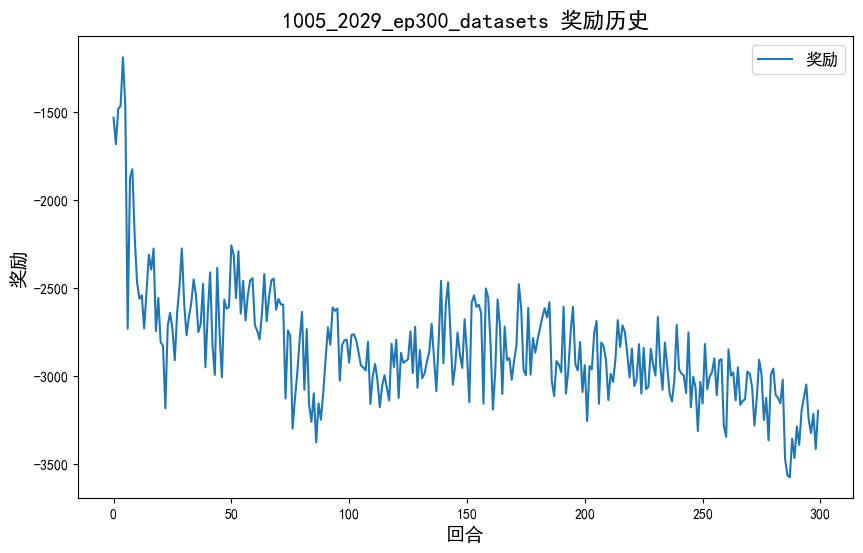

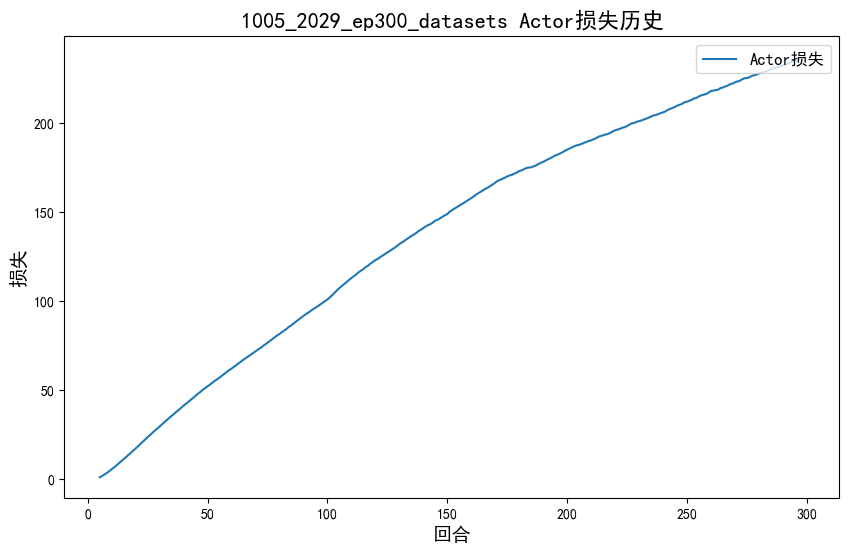

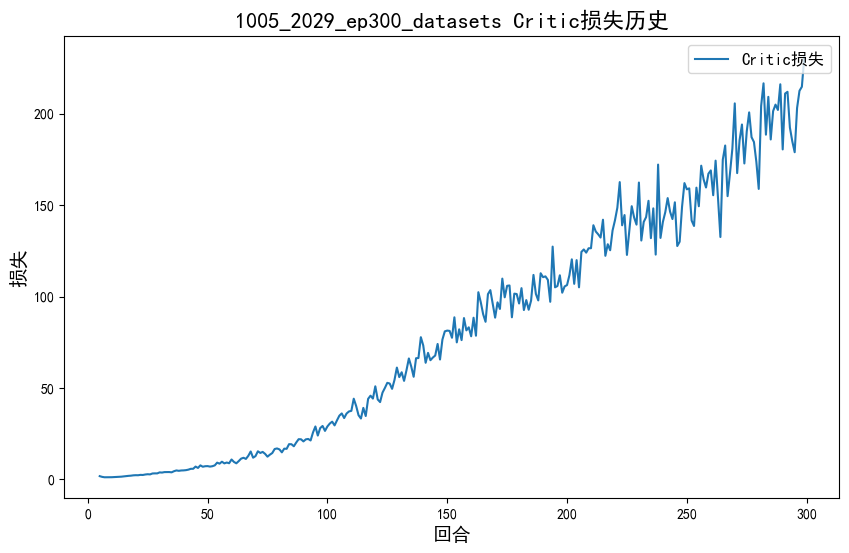

In [ ]:
# 训练历程数据
train_datasets.plot_episode_datas(save_path=project_path, show=True)  # 绘制训练的奖励历程数据图
train_datasets.plot_episode_datas(plot_rewards=False, plot_actor_losses=True, plot_critic_losses=True, show=True)  # 绘制训练历程数据图

仿真进度: 100%|██████████| 1000/1000 [00:02<00:00, 472.88it/s]


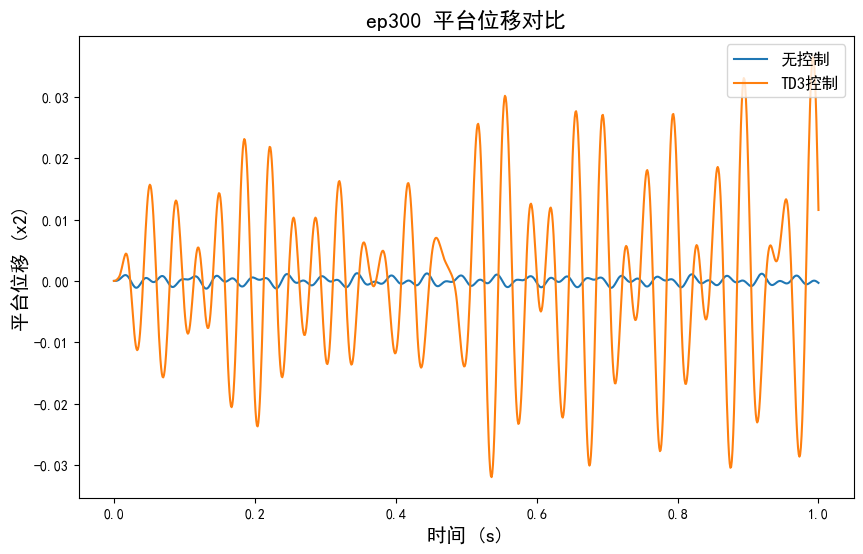

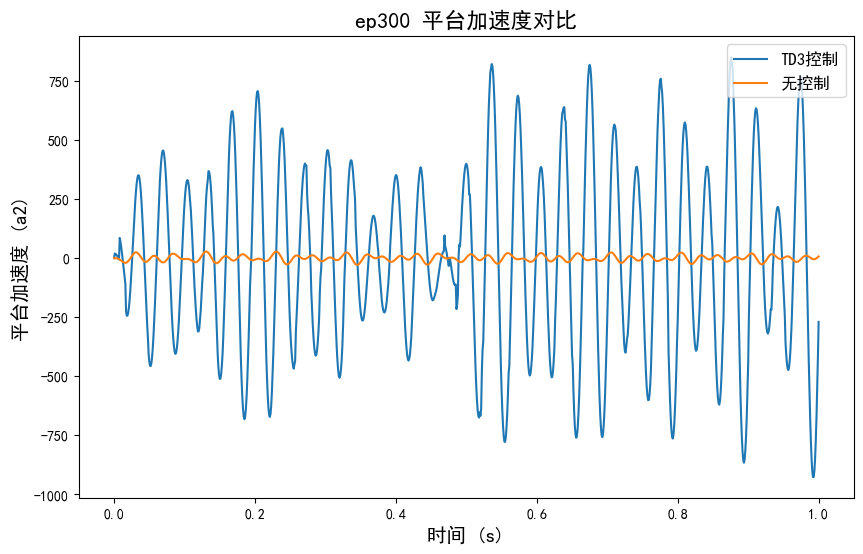

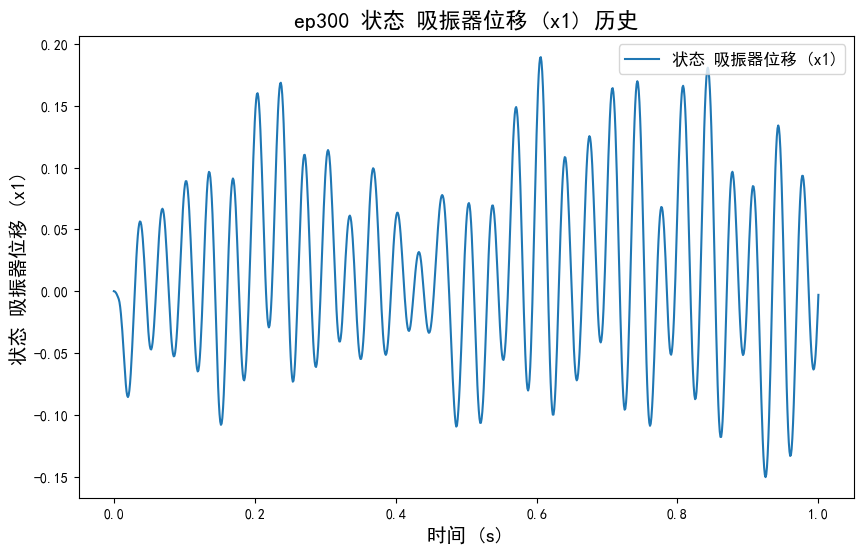

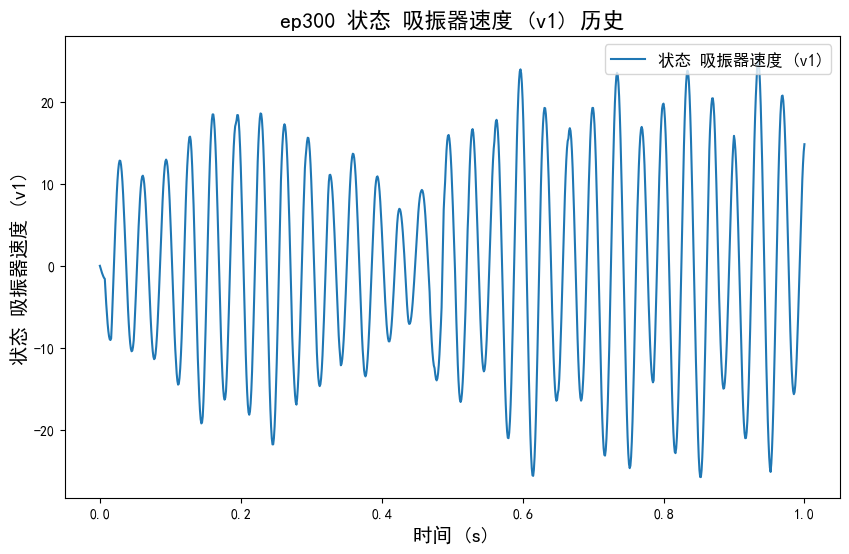

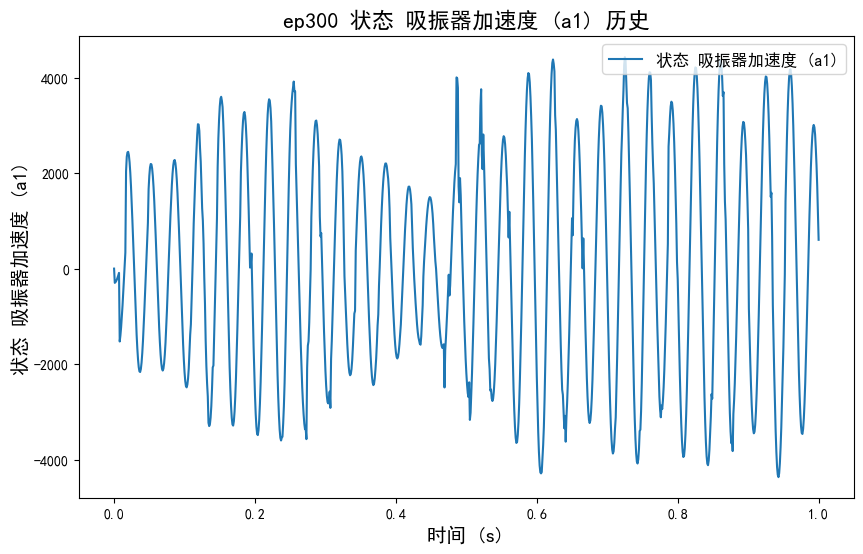

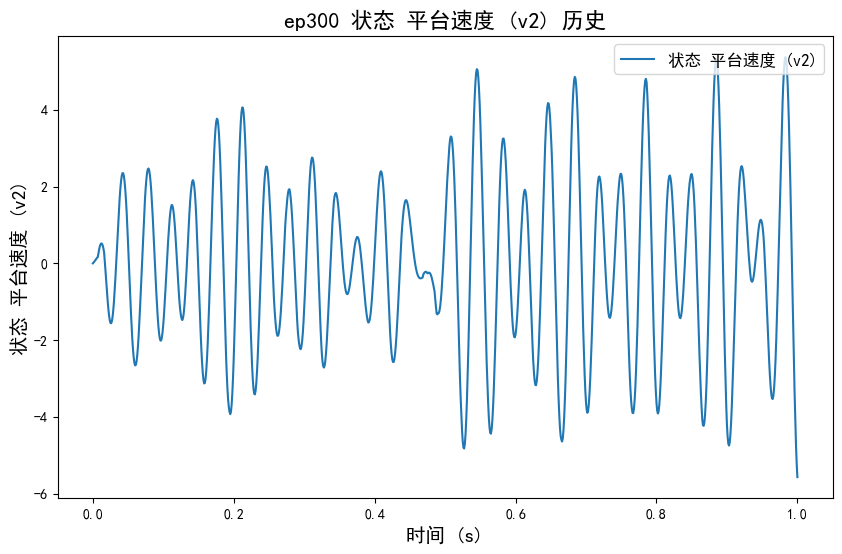

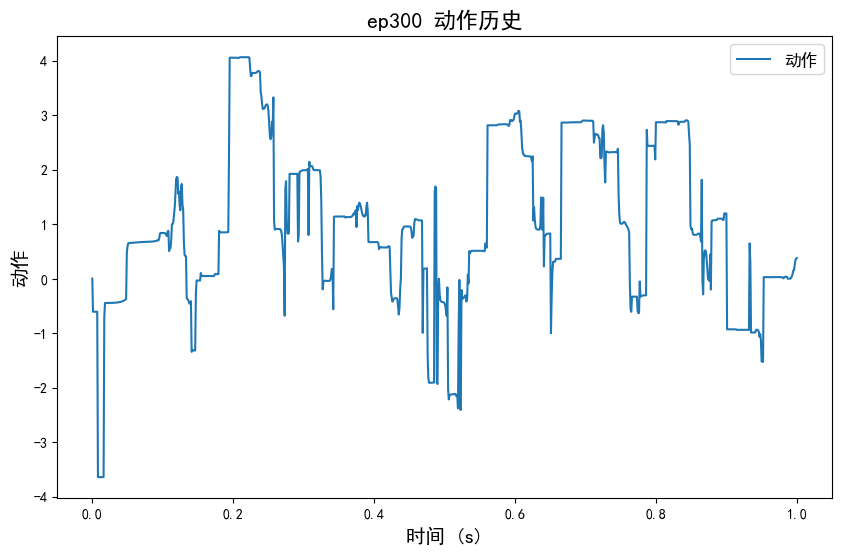

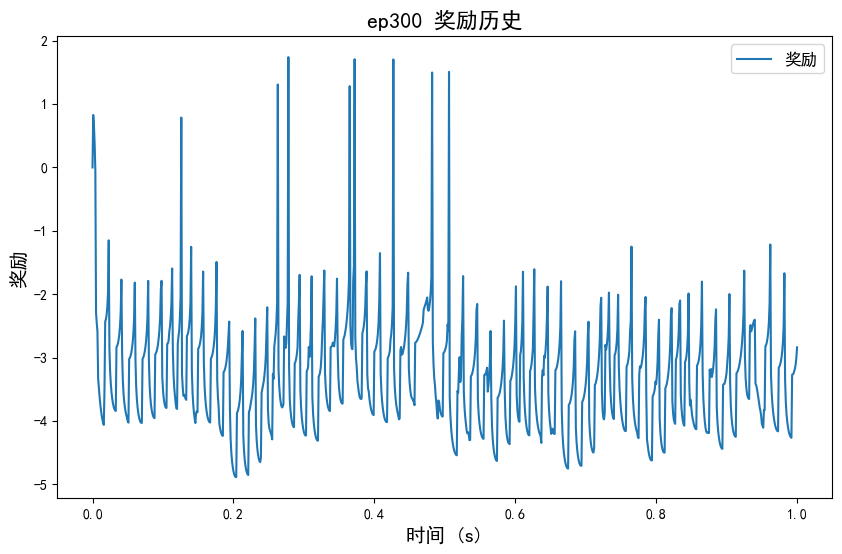

In [ ]:
# 训练对比
# env.all_state0 = np.zeros(6)
env.set_disturbance(zero)
env.set_force_function(f_func=f_func)
# env.set_force_function(sin_wave(amplitude=1000, frequency=300, phase=0))  # 设置扰动函数
# env.set_force_function(sin_wave(amplitude=200, frequency=30, phase=0))  # 设置扰动函数
# env.set_force_function(sin_wave(amplitude=300, frequency=40, phase=0))  # 设置扰动函数
nc_datasets = env.run_simulation() 
c_datasets = env.run_simulation(controller=agent)
c_datasets.checkpoint_name = f"ep{train_datasets.current_episode}"
plot_compare_no_control(nc_datasets, c_datasets, save_path=save_plot_path, use_time_noise=env.use_dt_noise, show=True)